## Testing out the `bracket_builder` package I was working on last year

In [1]:
import os
import sys
import pandas as pd
import bracket_builder.draw as bb
import bracket_builder.calculate as brac_calc

### Test out drawing standard 64 team bracket

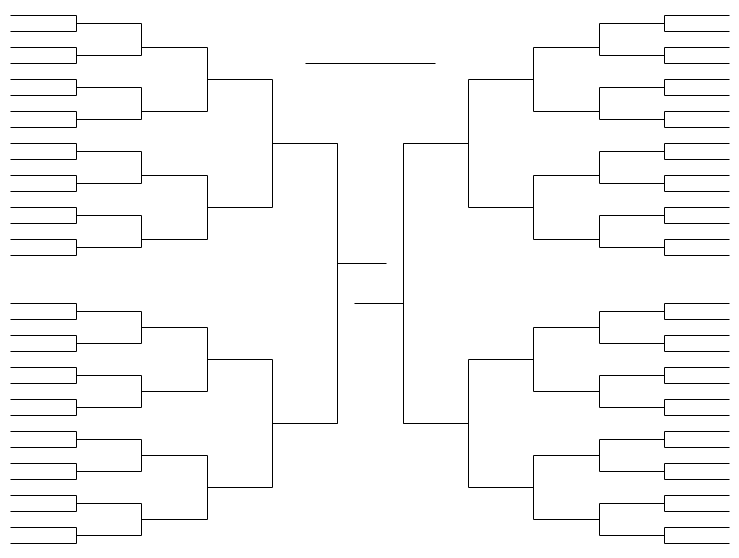

In [2]:
b = bb.Bracket(64)
b.draw_bracket()

### Adding names

In [3]:
os.chdir("../data/men/")

In [4]:
## Get past tournament data to test with
seeds = pd.read_csv("MNCAATourneySeeds.csv")
teams = pd.read_csv("MTeams.csv")
seeds = seeds.merge(teams[['TeamID', 'TeamName']])
ncaa_slots = pd.read_csv("MNCAATourneySlots.csv")

In [5]:
def remove_one_playin(ncaa_data):
    
    ### Remove the play-in seed with the seed starting with "b" for now
    #### Would ideally choose the one with the greater win prob. but doesn't matter much
    ncaa_data['seed_endswith_b'] = ncaa_data['Seed'].apply(lambda x: True if x.endswith('b') else False)
    ncaa_data = ncaa_data[~ncaa_data['seed_endswith_b']].copy()
    
    ## Change the Seed for the one starting with a
    ncaa_data['Seed'] = ncaa_data['Seed'].apply(lambda x: x[:-1] if x.endswith('a') else x)
    
    ## Drop the seed_endswith_b column
    ncaa_data = ncaa_data.drop(columns = ['seed_endswith_b'])
    
    return ncaa_data

In [6]:
### Limit to current season
seeds_2021 = seeds[seeds['Season'] == 2021].copy()

## Remove the 'b' play-in seeds and remove 'a' suffix from the deemed 'winner'
seeds_2021 = remove_one_playin(seeds_2021)

## Split the seed into Region and number parts
seeds_2021['seed_num']      = seeds_2021['Seed'].apply(lambda x: int(x[1:]))
seeds_2021['seed_region']   = seeds_2021['Seed'].apply(lambda x: x[0])
seeds_2021['seed_region_2'] = seeds_2021['seed_region'].apply(lambda x: 'W' if x == 'X'
                                                               else 'X' if x == 'W'
                                                               else 'Z' if x == 'Y'
                                                               else 'Y' if x == 'Z'
                                                               else x)

## Proper ordering for seeds within each region in the 1st round
seed_order = pd.DataFrame({'seed_num': [1, 16, 8, 9, 5, 12, 4, 13, 6, 11, 3, 14, 7, 10, 2, 15],
                           'seed_ord': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]})
seeds_2021 = seeds_2021.merge(seed_order)

## Sort it properly and check it out
seeds_2021 = seeds_2021.sort_values(['seed_region_2', 'seed_ord'])
seeds_2021.head(16)

,Season,Seed,TeamID,TeamName,seed_num,seed_region,seed_region_2,seed_ord
11,2021,X01,1211,Gonzaga,1,X,W,1
54,2021,X16,1111,Appalachian St,16,X,W,2
13,2021,X08,1328,Oklahoma,8,X,W,3
5,2021,X09,1281,Missouri,9,X,W,4
46,2021,X05,1166,Creighton,5,X,W,5
2,2021,X12,1364,UC Santa Barbara,12,X,W,6
41,2021,X04,1438,Virginia,4,X,W,7
48,2021,X13,1325,Ohio,13,X,W,8
38,2021,X06,1425,USC,6,X,W,9
19,2021,X11,1179,Drake,11,X,W,10


In [7]:
## Get submission for round 2
subs_path = "subs/submission_probs_untrimmed_2021-03-16.csv"
sub = pd.read_csv(subs_path)
sub['Season'] = sub['ID'].apply(lambda x: x.split('_')[0]).astype(int)
sub['TeamID_1']  = sub['ID'].apply(lambda x: x.split('_')[1]).astype(int)
sub['TeamID_2']  = sub['ID'].apply(lambda x: x.split('_')[2]).astype(int)

## Merge team 1 name
teams = teams.rename(columns={'TeamName': 'TeamName_1',
                              'TeamID': 'TeamID_1'})
teams = teams[['TeamName_1', 'TeamID_1']]
sub = sub.merge(teams, on='TeamID_1', how='left')

## Merge team 2 name
teams = teams.rename(columns={'TeamName_1': 'TeamName_2',
                              'TeamID_1': 'TeamID_2'})
sub = sub.merge(teams, on='TeamID_2', how='left')

sub.head()

,ID,Pred,Season,TeamID_1,TeamID_2,TeamName_1,TeamName_2
0,2021_1101_1104,0.133666,2021,1101,1104,Abilene Chr,Alabama
1,2021_1101_1111,0.844721,2021,1101,1111,Abilene Chr,Appalachian St
2,2021_1104_1111,0.970663,2021,1104,1111,Alabama,Appalachian St
3,2021_1101_1116,0.190191,2021,1101,1116,Abilene Chr,Arkansas
4,2021_1104_1116,0.588211,2021,1104,1116,Alabama,Arkansas


In [8]:
round_by_round_probs_df = brac_calc.compute_conditional_probs(subs_path, league = 'men')

round_by_round_probs_df.sort_values('Champ', ascending = False).head(20)

,TeamName,TeamID,Round1,Round2,Sweet16,Elite8,Final4,Final,Champ
19,Gonzaga,1211,1.0,0.992815,0.913223,0.789410,0.616534,0.472273,0.352892
31,Michigan,1276,1.0,0.987199,0.770096,0.599483,0.446359,0.207405,0.127266
23,Illinois,1228,1.0,0.973038,0.709832,0.559170,0.369554,0.241935,0.114064
5,Baylor,1124,1.0,0.979198,0.694086,0.491370,0.339108,0.188461,0.080453
22,Houston,1222,1.0,0.967645,0.773102,0.566624,0.312983,0.189637,0.080178
25,Iowa,1234,1.0,0.938625,0.752318,0.537761,0.206258,0.119182,0.066657
40,Ohio St,1326,1.0,0.946725,0.708171,0.464719,0.229036,0.106135,0.036687
1,Alabama,1104,1.0,0.956809,0.588675,0.379322,0.163310,0.048477,0.020680
61,Villanova,1437,1.0,0.831781,0.484880,0.183984,0.096154,0.037554,0.010559
29,Loyola-Chicago,1260,1.0,0.667267,0.222447,0.138503,0.065209,0.030005,0.008994


In [9]:
round_by_round_probs_df.to_csv("viz-files/round-by-round-probs-untrimmed-2021-03-16.csv", index = False)

In [12]:
## Submission with Michigan and Gonzaga manually scaled back some
subs_path = "subs/submission_probs_untrimmed_2021-03-17.csv"
round_by_round_probs_df = brac_calc.compute_conditional_probs(subs_path, league = 'men')
round_by_round_probs_df.to_csv("viz-files/round-by-round-probs-untrimmed-2021-03-17.csv", index = False)

round_by_round_probs_df.sort_values('Champ', ascending = False).head(20)

,TeamName,TeamID,Round1,Round2,Sweet16,Elite8,Final4,Final,Champ
19,Gonzaga,1211,1.0,0.990518,0.888144,0.735998,0.538689,0.417186,0.289057
23,Illinois,1228,1.0,0.973038,0.709832,0.559170,0.369554,0.241935,0.131817
5,Baylor,1124,1.0,0.979198,0.694086,0.491370,0.339108,0.188461,0.094091
22,Houston,1222,1.0,0.967645,0.773102,0.566624,0.312983,0.189637,0.093855
25,Iowa,1234,1.0,0.938625,0.752318,0.537761,0.242773,0.156540,0.087551
31,Michigan,1276,1.0,0.980961,0.690143,0.484984,0.321207,0.139277,0.072243
40,Ohio St,1326,1.0,0.946725,0.708171,0.464719,0.229036,0.106135,0.043696
1,Alabama,1104,1.0,0.956809,0.588675,0.379322,0.192913,0.066655,0.028434
61,Villanova,1437,1.0,0.831781,0.484880,0.183984,0.096154,0.037554,0.012796
62,Virginia,1438,1.0,0.812380,0.501918,0.131100,0.058852,0.028348,0.011037


### Plot what it predicts!


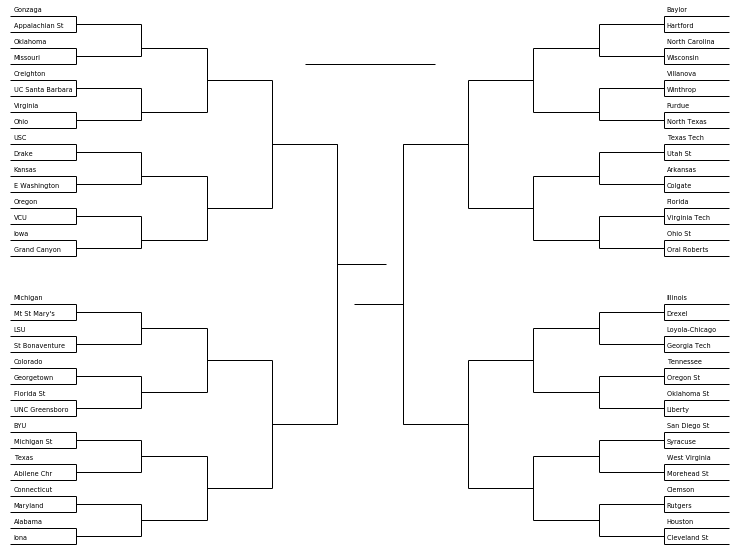

In [11]:
### Label team names (note: had to switch 'Z' and 'Y' region labels.)
b_2 = bb.Bracket(n_teams = 64, team_names = list(seeds_2021['TeamName']))
b_2.draw_bracket()
b_2.label_teams()

## To-Do

  1. Fix up the `label_winners()` function and/or get a pipeline to easily get winners in required order
  2. Complete the `draw_weighted_lines()` function to draw lines in the team's colors.
  3. Get a pipeline in `calculate` going to `compute_conditional_probs()` in a way that works seamlessly with weighted lines.